In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import variable
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import random
import xml.etree.ElementTree as ET

In [ ]:
from torch.utils.data import Dataset

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
eng_alphabets = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
pad_char ='-PAD-'
eng_alpha2index = {pad_char:0}
for index,letter in enumerate(eng_alphabets):
    eng_alpha2index[letter] = index+1

print(eng_alpha2index)

{'-PAD-': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26}


In [ ]:
hindi_alphabets = [chr(alpha) for alpha in range(2304,2432)]
hindi_alphabets_size = len(hindi_alphabets)

hindi_alpha2index = {pad_char:0}
for index,letter in enumerate(hindi_alphabets):
    hindi_alpha2index[letter] = index+1

print(hindi_alpha2index)

{'-PAD-': 0, 'ऀ': 1, 'ँ': 2, 'ं': 3, 'ः': 4, 'ऄ': 5, 'अ': 6, 'आ': 7, 'इ': 8, 'ई': 9, 'उ': 10, 'ऊ': 11, 'ऋ': 12, 'ऌ': 13, 'ऍ': 14, 'ऎ': 15, 'ए': 16, 'ऐ': 17, 'ऑ': 18, 'ऒ': 19, 'ओ': 20, 'औ': 21, 'क': 22, 'ख': 23, 'ग': 24, 'घ': 25, 'ङ': 26, 'च': 27, 'छ': 28, 'ज': 29, 'झ': 30, 'ञ': 31, 'ट': 32, 'ठ': 33, 'ड': 34, 'ढ': 35, 'ण': 36, 'त': 37, 'थ': 38, 'द': 39, 'ध': 40, 'न': 41, 'ऩ': 42, 'प': 43, 'फ': 44, 'ब': 45, 'भ': 46, 'म': 47, 'य': 48, 'र': 49, 'ऱ': 50, 'ल': 51, 'ळ': 52, 'ऴ': 53, 'व': 54, 'श': 55, 'ष': 56, 'स': 57, 'ह': 58, 'ऺ': 59, 'ऻ': 60, '़': 61, 'ऽ': 62, 'ा': 63, 'ि': 64, 'ी': 65, 'ु': 66, 'ू': 67, 'ृ': 68, 'ॄ': 69, 'ॅ': 70, 'ॆ': 71, 'े': 72, 'ै': 73, 'ॉ': 74, 'ॊ': 75, 'ो': 76, 'ौ': 77, '्': 78, 'ॎ': 79, 'ॏ': 80, 'ॐ': 81, '॑': 82, '॒': 83, '॓': 84, '॔': 85, 'ॕ': 86, 'ॖ': 87, 'ॗ': 88, 'क़': 89, 'ख़': 90, 'ग़': 91, 'ज़': 92, 'ड़': 93, 'ढ़': 94, 'फ़': 95, 'य़': 96, 'ॠ': 97, 'ॡ': 98, 'ॢ': 99, 'ॣ': 100, '।': 101, '॥': 102, '०': 103, '१': 104, '२': 105, '३': 106, '४': 107, '५': 108, '६': 109, '७': 

In [ ]:

non_eng = re.compile('[^a-zA-Z ]')

def cleanEnglishVocab(line):
    line = line.replace('-',' ').replace(',', ' ').upper()
    line = non_eng.sub('',line)
    return line.split()

def cleanHindiVocab(line):
    line = line.replace('-',' ').replace(',', ' ')
    cleaned_line =''
    for char in line:
        if char in hindi_alpha2index or char == ' ':
            cleaned_line += char
    return cleaned_line.split()

In [ ]:
class TransliterationDataLoader(Dataset):

    def __init__(self,filename):
        self.eng_words, self.hindi_words = self.readXmlDataset(filename,cleanHindiVocab)
        self.shuffle_indices = list(range(len(self.eng_words)))
        random.shuffle(self.shuffle_indices)
        self.shuffle_start_index = 0

    def __len__(self):
        return len(self.eng_words)

    def __getitem__(self,index):
        return self.eng_words[index], self.hindi_words[index]

    def readXmlDataset(self,filename,lang_vocab_cleaner):
        translierationCorpus = ET.parse(filename).getroot()
        eng_words = []
        hindi_words = []
        for word in translierationCorpus:
            wordlist1 = cleanEnglishVocab(word[0].text)
            wordlist2 = lang_vocab_cleaner(word[1].text)

            if len(wordlist1) != len(wordlist2):
                print('Skipping',word[0].text,'-',word[1].text)
                continue
            for word in wordlist1:
                eng_words.append(word)
            for word in wordlist2:
                hindi_words.append(word)
        return eng_words, hindi_words

    def get_random_sample(self):
        return self.__getitem__(np.random.randint(len(self.eng_words)))


    def get_batch_from_array(self,batch_size,array):
        end = self.shuffle_start_index + batch_size
        batch = []
        if end  >= len(self.eng_words):
            batch = [array[i] for i in self.shuffle_indices[0:end%len(self.eng_words)]]
            end = len(self.eng_words)
        return batch + [array[i] for i in self.shuffle_indices[self.shuffle_start_index:end]]


    def get_batch(self,batch_size,postprocess=True):
        eng_batch = self.get_batch_from_array(batch_size,self.eng_words)
        hindi_batch = self.get_batch_from_array(batch_size,self.hindi_words)
        self.shuffle_start_index += batch_size + 1
        if self.shuffle_start_index >= len(self.eng_words):
            random.shuffle(self.shuffle_indices)
            self.shuffle_start_index = 0
        return eng_batch, hindi_batch

In [ ]:
train_data = TransliterationDataLoader('./NEWS2012-Training-EnHi-13937.xml')
test_data = TransliterationDataLoader('./NEWS2012-Ref-EnHi-1000.xml')

Skipping BARHARWA JUNCTION - बरहरवा
Skipping STATE BNK TR - स्टेट बैंक ऑफ त्रावणकोर
Skipping SOUTH ARLINGTON CHURCH OF CHRIST - साउथ अर्लिंग्टन
Skipping KING EDWARD VII - किंग एडवर्ड
Skipping DIBANG VALLEY - दिबंगवैली
Skipping ORDER OF VASA - ऑडर ऑफ़ द वासा
Skipping AZAMNAGAR ROAD - आज़मनगर
Skipping CAPE TOWN - केपटाउन
Skipping NEW ZEALAND - न्यूज़ीलैंड
Skipping SEA OF THE HEBRIDES - सी ऑफ हरब्रिड्‍स
Skipping RAMCOIND - राम्को इंड
Skipping KELVINGROVE ART GALLERY AND MUSEUM - केल्व‍िनग्रोव आर्ट एण्ड म्युज़ियम
Skipping AUSTRALIAN NATIONAL UNIVERSITY - ऑस्ट्रेलियननेशनल यूनिवर्सिटी
Skipping JAHAN AARA - जहाँआरा
Skipping NAVABHARAT FERRO ALLOYS - नव भारत फ़ैरो अलॉय
Skipping RAMA LINGESHWARA - रामालिंगेश्वर
Skipping FAKHRUN NISA - फखरुन्निसा
Skipping REDIFF.COM INDIA LIMITED - रेडिफ़ डॉट कॉम इंडिया लिमिटेड
Skipping OMKARNATH THAKUR - ओंकार नाथ ठाकुर
Skipping OPENTV - ओपन टीवी
Skipping ENVOY COMMUNICATIONS GROUP - एन्वॉय कम्युनिकेशंस
Skipping WAR OF THE HOLY LEAGUE - वार ऑफ होली लीग
Skipping VA

In [ ]:
for i in range(10):
    eng,hindi = train_data.get_random_sample()
    print(eng + '-' + hindi)

BLOCKHOUSE-ब्लॉकहाउस
PHANSI-फाँसी
MUJAFFARPUR-मुज़फ़्फ़रपुर
ABBAD-अब्बाद
SAMEERA-समीरा
KRIKOR-क्रिकोर
FORT-फोर्ट
NAMAK-नमक
SARKAR-सरकार
YOGITA-योगिता


In [ ]:
def word_rep(word,letter2index):
    rep = torch.zeros(len(word)+1,1,len(letter2index)).to(device)
    for index,letter in enumerate(word):
        rep[index+1,0,letter2index[letter]] = 1
    rep[0,0,letter2index[pad_char]] = 1
    return rep

In [ ]:
def gt_rep(word,letter2index):
    rep = torch.zeros([len(word)+1,1],dtype=torch.long).to(device)
    for index,letter in enumerate(word):
        rep[index][0] = letter2index[letter]
    rep[index+1][0] = letter2index[pad_char]
    return rep

In [ ]:
eng,hindi = train_data.get_random_sample()
print(eng+ '-' + hindi)
word_rep(eng,eng_alpha2index)

SULALITA-सुललिता


tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
     

In [ ]:
gt_rep(hindi,hindi_alpha2index)

tensor([[57],
        [66],
        [51],
        [51],
        [64],
        [37],
        [63],
        [ 0]], device='cuda:0')

In [ ]:
MAX_OUTPUT_CHARS = 30
class Transliteration_EncoderDecoder(nn.Module):
    def __init__(self,input_size,hidden_size,output_size, verbose=False):
        super(Transliteration_EncoderDecoder,self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.verbose = verbose

        self.encoder = nn.GRU(input_size,hidden_size)
        self.decoder = nn.GRU(output_size,hidden_size)
        self.h2o = nn.Linear(hidden_size,output_size)
        self.softmax = nn.LogSoftmax(dim=2)
        self.to(device)

    def forward(self,input,max_output_chars = MAX_OUTPUT_CHARS,ground_truth = None):
        #ENCODER
        output,hidden = self.encoder(input)

        #if self.verbose:
            #print('Encoder input shape:',input.shape)
            #print('Encoder output shape:',output.shape)
            #print('Encoder hidden shape:',hidden.shape)

        #DECODER
        decoder_state = hidden
        decoder_input = torch.zeros(1,1,self.output_size).to(device)
        outputs = []

        #if self.verbose:
            #print('Decoder State', decoder_state.shape)
           # print('Decoder input', decoder_input.shape)

        for i in range(max_output_chars):
            decoder_output, decoder_state = self.decoder(decoder_input,decoder_state)

            #if self.verbose:
               # print('Decoder hidden shape:',decoder_output.shape)

            decoder_output = self.h2o(decoder_state)
            decoder_output = self.softmax(decoder_output)
            outputs.append(decoder_output.view(1,-1))

            if self.verbose:
                #print('Decoder output shape:',decoder_output.shape)
                self.verbose = False

            max_idx = torch.argmax(decoder_output,dim=2,keepdim=True)
            if not ground_truth is None:
              max_idx = ground_truth[i].reshape(1,1,1)
            one_hot = torch.zeros_like(decoder_output)
            #one_hot.zero_()
            one_hot.scatter_(2,max_idx,1)
            decoder_input = one_hot.detach()
        return outputs

In [ ]:
net = Transliteration_EncoderDecoder(len(eng_alpha2index),256,len(hindi_alpha2index),verbose=True)

In [ ]:
def infer(net, word, max_output_chars):
    word_ohe = word_rep(list(word), eng_alpha2index)
    outputs = net(word_ohe, max_output_chars)
    return outputs

In [ ]:
out = infer(net,'INDIA',30)

In [ ]:
MAX_OUTPUT_CHARS = 30
class Transliteration_EncoderDecoder_Attention(nn.Module):
    def __init__(self,input_size,hidden_size,output_size, verbose=False):
        super(Transliteration_EncoderDecoder_Attention,self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.verbose = verbose

        self.encoder = nn.GRU(input_size,hidden_size)
        self.decoder = nn.GRU(hidden_size*2,hidden_size)
        self.h2o = nn.Linear(hidden_size,output_size)
        self.softmax = nn.LogSoftmax(dim=2)

        self.U = nn.Linear(self.hidden_size,self.hidden_size)
        self.W = nn.Linear(self.hidden_size,self.hidden_size)
        self.attn = nn.Linear(self.hidden_size,1)
        self.out2hidden = nn.Linear(self.output_size,self.hidden_size)
        self.to(device)

    def forward(self, input, max_output_chars=MAX_OUTPUT_CHARS, ground_truth=None):
        # ENCODER
        encoder_output, hidden = self.encoder(input)
        encoder_output = encoder_output.squeeze(1)

        # DECODER
        decoder_state = hidden
        decoder_input = torch.zeros(1, 1, self.output_size).to(device)
        outputs = []
        U = self.U(encoder_output)

        for i in range(max_output_chars):
            decoder_state_ = decoder_state.squeeze(0).squeeze(0)
            W = self.W(decoder_state_)
            W = W.unsqueeze(0).repeat(encoder_output.shape[0], 1)
            V = self.attn(torch.tanh(U + W))

            attn_weights = F.softmax(V, dim=0)

            attn_applied = torch.mm(attn_weights.T, encoder_output)
            embedding = self.out2hidden(decoder_input)
            decoder_input = torch.cat((embedding, attn_applied.unsqueeze(0)), dim=2)
            decoder_output, decoder_state = self.decoder(decoder_input, decoder_state)
            decoder_output = self.h2o(decoder_state)
            decoder_output = self.softmax(decoder_output)
            outputs.append(decoder_output.view(1, -1))

            max_idx = torch.argmax(decoder_output, dim=2, keepdim=True)
            if ground_truth is not None:
                max_idx = ground_truth[i].reshape(1, 1, 1)
            one_hot = torch.zeros_like(decoder_output)
            one_hot.scatter_(2, max_idx, 1)
            decoder_input = one_hot.detach()

        return outputs

In [ ]:
net = Transliteration_EncoderDecoder_Attention(len(eng_alpha2index),256,len(hindi_alpha2index),verbose=True)

In [ ]:
def train_batch(net, opt, criterion, batch_size, teacher_force=False):
    net.train()
    opt.zero_grad()
    eng_batch, hindi_batch = train_data.get_batch(batch_size)
    total_loss = 0

    for i in range(batch_size):
        eng_ohe = word_rep(eng_batch[i], eng_alpha2index)
        hindi_gt = gt_rep(hindi_batch[i], hindi_alpha2index)
        outputs = net(eng_ohe, max_output_chars=hindi_gt.shape[0], ground_truth=hindi_gt if teacher_force else None)

        loss = 0
        for idx, out in enumerate(outputs):
            loss += criterion(out, hindi_gt[idx])
        loss = loss / batch_size
        loss.backward()
        total_loss += loss.item()
        #torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=5.0)

    opt.step()
    return total_loss / batch_size

In [ ]:
def train_setup(net,lr = 0.001,n_batches = 100, batch_size = 10, momentum = 0.9, display_freq = 5):
    criterion = nn.NLLLoss(ignore_index=-1).to(device)
    opt = optim.Adam(net.parameters(),lr=lr)
    teacher_force_upto = n_batches//3
    loss_arr = np.zeros(n_batches+1)

    for i in range(n_batches):
        loss_arr[i+1] = (loss_arr[i]* i + train_batch(net,opt,criterion,batch_size, teacher_force= i<teacher_force_upto))/(i+1)
        if i%display_freq == display_freq-1:
            clear_output(wait=True)

            print('Iteration',i, 'Loss', loss_arr[i])
            plt.figure()
            plt.plot(loss_arr[1:i],'-*')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n\n')
    torch.save(net,'model.pt')
    return loss_arr

In [ ]:
net = Transliteration_EncoderDecoder(len(eng_alpha2index),256,len(hindi_alpha2index),verbose=True)
net.to(device)

Transliteration_EncoderDecoder(
  (encoder): GRU(27, 256)
  (decoder): GRU(129, 256)
  (h2o): Linear(in_features=256, out_features=129, bias=True)
  (softmax): LogSoftmax(dim=2)
)

Iteration 2499 Loss 0.07238032317529156


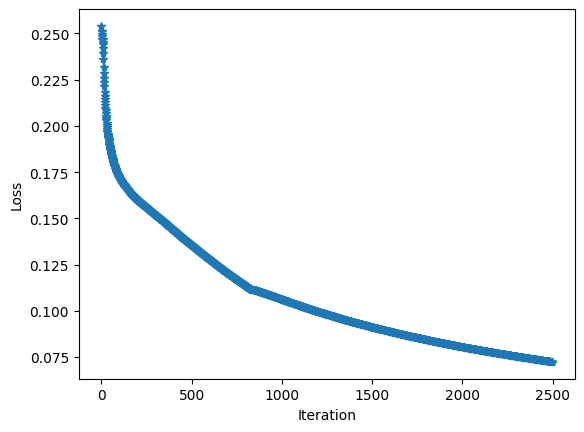

array([0.        , 0.25404988, 0.24695769, ..., 0.07239287, 0.07238032,
       0.07236599])

In [ ]:
train_setup(net, lr=0.001, n_batches= 2500, batch_size=128, display_freq=5)

In [ ]:
net_attn = Transliteration_EncoderDecoder_Attention(len(eng_alpha2index),256,len(hindi_alpha2index),verbose=True)
net_attn.to(device)

Transliteration_EncoderDecoder_Attention(
  (encoder): GRU(27, 256)
  (decoder): GRU(512, 256)
  (h2o): Linear(in_features=256, out_features=129, bias=True)
  (softmax): LogSoftmax(dim=2)
  (U): Linear(in_features=256, out_features=256, bias=True)
  (W): Linear(in_features=256, out_features=256, bias=True)
  (attn): Linear(in_features=256, out_features=1, bias=True)
  (out2hidden): Linear(in_features=129, out_features=256, bias=True)
)

Iteration 2499 Loss 0.05367061867384105


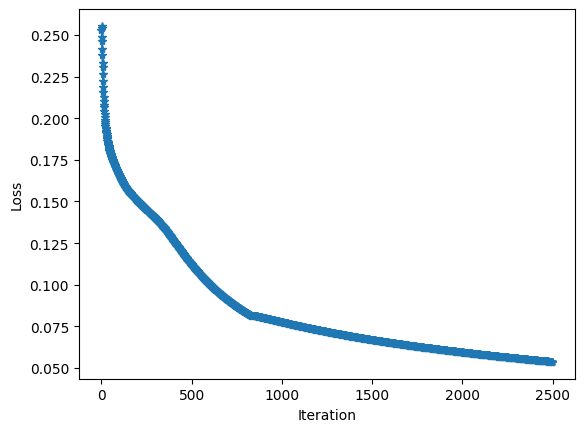

array([0.        , 0.2527363 , 0.25540788, ..., 0.05368074, 0.05367062,
       0.05365996])

In [ ]:
train_setup(net_attn, lr=0.001, n_batches=2500, batch_size=128, display_freq=5)

In [ ]:
def calc_acc(net):
    net.eval()
    predictions = []
    acc = 0
    for i in range(len(test_data)):
        eng,hindi = test_data[i]
        gt = gt_rep(hindi,hindi_alpha2index)
        outputs = infer(net,eng,gt.shape[0])
        correct = 0
        for index,char in enumerate(outputs):
            val,indices = char.topk(1)
            hindi_pos = indices.tolist()[0]
            if hindi_pos[0] == gt[index][0]:
                correct += 1
        acc += correct/gt.shape[0]
    return acc/len(test_data)

In [ ]:
accuracy = calc_acc(net)*100
accuracy_attn = calc_acc(net_attn)*100
print('Accuracy without attention:',accuracy)
print('Accuracy with attention:',accuracy_attn)

Accuracy without attention: 69.29829947829947
Accuracy with attention: 75.3074977799978


In [ ]:
def test(net,word):
    net.eval()
    outputs = infer(net,word,30)
    hindi_output = ''
    for output in outputs:
        val,indices = output.topk(1)
        hindi_pos = indices.tolist()[0]
        if hindi_pos[0] == 0:
            break
        hindi_output += hindi_alphabets[hindi_pos[0]]
    print(word +'-' + hindi_output)
    return hindi_output

In [ ]:
test(net,'')

HOME-ऺौय


'ऺौय'

In [ ]:
test(net_attn,'HOME')

HOME-ऺौय


'ऺौय'